# Agent Generative Tracking Simulation and Inference Models

This project involves the exploration and implementation of generative models and Bayesian inference within the Julia programming language using the Gen probabilistic programming library. Three distinct models were created: the Random Walk Model, the New Yorker Model, and the Tourist Model. These models simulate the movement of an agent in a 2D space with varying degrees of randomness and goal-directed behavior. The project also introduces a Switch Combinator Model, allowing for the selection of different generative models based on a specified probability distribution. Bayesian inference was applied to infer the model choices given observed data. The project culminates in a comprehensive exploration of generative models, their combination, and Bayesian inference techniques, showcasing the flexibility and expressive power of probabilistic programming in scientific simulations.

## Importing the Libraries and Enviornments

In [1]:
#using Pkg;

#Pkg.add("Gen")
#Pkg.add("Plots")
#Pkg.add("Random")
#Pkg.add("Distributions")

In [3]:
using Gen;
using Plots;
using Random;
using Distributions

## Constructing and Limiting the State Space

In [4]:
struct TruncNorm <: Gen.Distribution{Float64} end

const trunc_norm = TruncNorm()

function Gen.random(::TruncNorm, mu::Float64, noise::Float64, low::Float64, high::Float64)
    d = Distributions.Truncated(Distributions.Normal(mu, noise), low, high)
    return Distributions.rand(d)
end

function Gen.logpdf(::TruncNorm, x::Float64, mu::Float64, noise::Float64, low::Float64, high::Float64)
    d = Distributions.Truncated(Distributions.Normal(mu, noise), low, high)
    return Distributions.logpdf(d, x)
end


## Creating the Random Walk Model

In [5]:
@gen function randomWalkModel(T::Int, initX, initY)

    measurement_noise = 0.005
    step_var = 1e-2

    xs = Vector{Float64}(undef, T+1)
    ys = Vector{Float64}(undef, T+1)

    # Setting initial x-coordinate
    x = initX

    # Setting initial y-coordinate
    y = initY
    
    # Record position
    xs[1] = x
    ys[1] = y
    
    # Declare prior for the noise
    noise ~ trunc_norm(0.0, 1.0, 0.0, 5.0)  # Adjust parameters as needed
    
    # Generate successive states and measurements
    for t=1:T
        x = {(:step => t => :x)} ~ trunc_norm(xs[t], noise, 0.0, 5.0)
        y = {(:step => t => :y)} ~ trunc_norm(ys[t], noise, 0.0, 5.0)

        # record position
        xs[t+1] = x
        ys[t+1] = y
    end

    # Return the sequence of positions
    return (xs, ys)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##randomWalkModel#292", Bool[0, 0, 0], false)

In [6]:
# Test out the model
randomWalkModel(20, 0.0, 0.0)

([0.0, 0.11148258080797424, 0.7178552660503427, 3.4904248868203323, 3.9495546823636047, 3.107289146359265, 2.2858856555208082, 2.3362992623545673, 2.595768736074695, 3.643141307747065  …  3.183631840929132, 3.2459825425473428, 4.125197274058631, 2.5308055158514104, 2.980673185116924, 3.600203531543254, 3.605301750400424, 4.310438696363848, 4.140493935402532, 4.321267641105805], [0.0, 0.957558573160817, 1.125841142743001, 2.8528567017765365, 4.184475124818018, 3.9756488567652126, 2.169688451580898, 1.1733286608836604, 3.117434700096937, 1.889299104867916  …  1.8489696466055618, 0.7676081603976006, 1.599591264064866, 1.8533321268355958, 1.8577584600162331, 3.5760244139283097, 3.883140431786399, 3.0450479021192325, 3.187953432944469, 1.333131394051834])

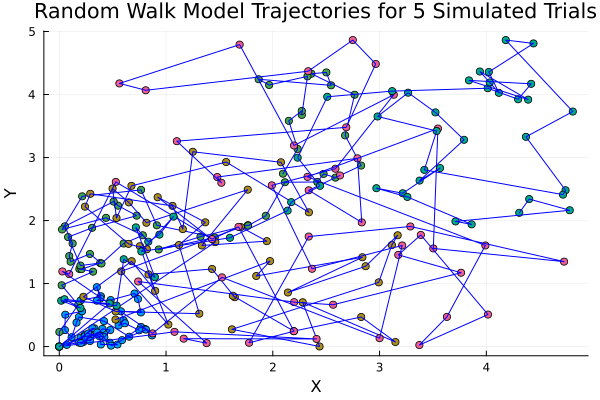

In [7]:
# Simulate and plot randomWalkModel
T = 50
num_trials = 5
initX_rw, initY_rw = 0.0, 0.0

plt_rw = plot(title="Random Walk Model Trajectories for $num_trials Simulated Trials", xlabel="X", ylabel="Y")

for _ in 1:num_trials
    trace_rw = Gen.simulate(randomWalkModel, (T, initX_rw, initY_rw))
    xs_rw, ys_rw = get_retval(trace_rw)

    # Plot the steps with lines
    plot!(plt_rw, xs_rw, ys_rw, label=nothing, seriestype=:scatter, legend=false)
    plot!(plt_rw, xs_rw, ys_rw, label=nothing, color=:blue, linewidth=1, seriestype=:path)
end

display(plt_rw)


[ Info: Saved animation to /vast/palmer/home.grace/psyc261_mi337/Algorithms-of-the-Mind/term_project/tmp.gif


Plots.AnimatedGif("/vast/palmer/home.grace/psyc261_mi337/Algorithms-of-the-Mind/term_project/tmp.gif")
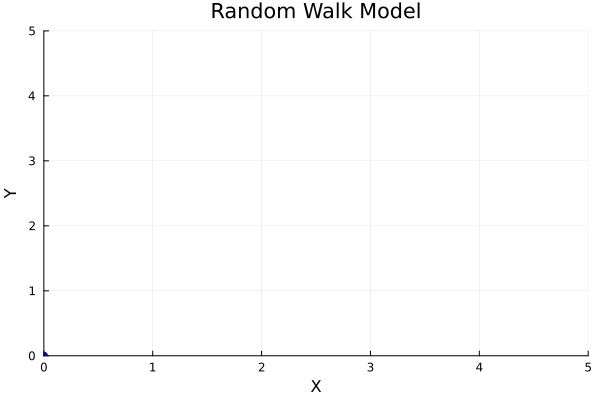

In [8]:
# Simulate and animate randomWalkModel with grid
function animate_random_walk_grid(T::Int, initX, initY; num_traces = 1, fps = 3)
    # Specify a color palette for each trace
    color_palette = [:blue, :green, :red, :purple, :orange]

    anim = @animate for t in 1:T
        for trace_id in 1:num_traces
            trace = Gen.simulate(randomWalkModel, (T, initX, initY))
            xs, ys = get_retval(trace)
            # Specify color for each trace
            scatter!(plot(), [xs[t]], [ys[t]], title = "Random Walk Model", xlabel = "X", ylabel = "Y", label=nothing, seriestype=:scatter, color=color_palette[trace_id], xlims=(0,5), ylims=(0,5))
        end
    end

    gif(anim, fps = fps)
end

# Simulate and animate randomWalkModel with grid
T = 50
initX_rw, initY_rw = 0.0, 0.0
animate_random_walk_grid(T, initX_rw, initY_rw)


### Creating the Goal Directed Model

In [9]:
@gen function goalDirectedModel(T::Int, initX, initY)
    measurement_noise = 0.005
    step_var = 1e-2

    xs = Vector{Float64}(undef, T+1)
    ys = Vector{Float64}(undef, T+1)

    # Setting initial x-coordinate
    x = initX

    # Setting initial y-coordinate
    y = initY
   
    # Record position
    xs[1] = x
    ys[1] = y
   
    # Sample goalX and goalY between 0 and 5
    goalX, goalY = @trace(uniform(0.0, 5.0), :goalX), @trace(uniform(0.0, 5.0), :goalY)
   
    # Declare prior for the noise
    noise ~ trunc_norm(0.0, 1.0, 0.0, 5.0)  # Adjust parameters as needed
   
    # Generate successive states and measurements
    for t=1:T
        # Calculate the direction and distance to the goal
        dx = goalX - x
        dy = goalY - y

        # Add some uncertainty
        dx += normal(0.0, 0.2)
        dy += normal(0.0, 0.2)

        # Normalize the direction vector
        norm_factor = sqrt(dx^2 + dy^2)
        dx /= norm_factor
        dy /= norm_factor

        # Take a step towards the goal using trunc_norm
        step_size_x = {(:step => t => :x)} ~ trunc_norm(0.0, sqrt(step_var), 0.0, 5.0)
        step_size_y = {(:step => t => :y)} ~ trunc_norm(0.0, sqrt(step_var), 0.0, 5.0)

        # Record position
        x += normal(step_size_x * dx, 1e-6)
        y += normal(step_size_y * dy, 1e-6)
        
        xs[t+1] = x
        ys[t+1] = y
    end

    # Return the sequence of positions and sampled goal coordinates
    return (xs, ys, goalX, goalY)
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##goalDirectedModel#346", Bool[0, 0, 0], false)

In [10]:
goalDirectedModel(20, 0.0, 0.0)

([0.0, 0.08631274795514064, 0.19681993875947892, 0.2727743119121787, 0.3247151871658604, 0.3945690768320998, 0.441765075195096, 0.4857119460922645, 0.5147414669327114, 0.6117922855401079  …  0.6237048028406791, 0.7541710618071317, 0.828703864992983, 0.8648392829686516, 0.9030616465245709, 0.9741183114838151, 1.0402781617337544, 1.1028035354267216, 1.1912347902511493, 1.2471477445725228], [0.0, 0.01573637534222067, 0.14372737264797483, 0.270869366400173, 0.31585717784118644, 0.3312612598204057, 0.34385520590115204, 0.4191649473711911, 0.45890150841495553, 0.4747754686642277  …  0.5326511590452013, 0.6186911631181593, 0.7519804896655585, 0.7974946773360795, 0.8151530452915737, 0.9218861882635281, 0.9481657721578954, 1.0390178270508952, 1.0821664743019788, 1.1851749426261018], 3.8814297115569776, 4.45110059317894)

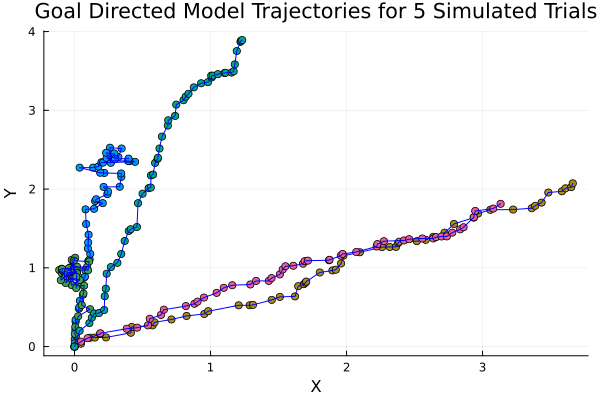

In [11]:
# Simulate multiple trials
T = 50
num_trials = 5
initX_rw, initY_rw = 0.0, 0.0

plt_rw = plot(title="Goal Directed Model Trajectories for $num_trials Simulated Trials", xlabel="X", ylabel="Y")

for _ in 1:num_trials
    trace_rw = Gen.simulate(goalDirectedModel, (T, initX_rw, initY_rw))
    xs_rw, ys_rw, goalX, goalY = get_retval(trace_rw)

    # Plot the steps with lines
    plot!(plt_rw, xs_rw, ys_rw, label=nothing, seriestype=:scatter, legend=false)
    plot!(plt_rw, xs_rw, ys_rw, label=nothing, color=:blue, linewidth=1, seriestype=:path)
end

display(plt_rw)


[ Info: Saved animation to /vast/palmer/home.grace/psyc261_mi337/Algorithms-of-the-Mind/term_project/tmp.gif


Plots.AnimatedGif("/vast/palmer/home.grace/psyc261_mi337/Algorithms-of-the-Mind/term_project/tmp.gif")
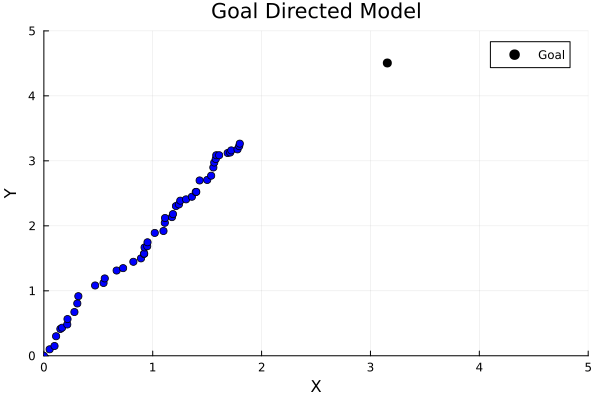

In [12]:
# Simulate trajectories
function animate_goal_directed_grid(T::Int, initX, initY; num_traces = 1, fps = 3, plot_goal = false)
    # Specify a color palette for each trace
    color_palette = [:blue, :green, :red, :purple, :orange]

    plt = plot()

    anim = @animate for trace_id in 1:num_traces
        trace = Gen.simulate(goalDirectedModel, (T, initX, initY))
        xs, ys, goalX, goalY = get_retval(trace)

        # Plot the goal
            if plot_goal
                plt = scatter!([goalX], [goalY], label="Goal", color=:black, markersize=5, seriestype=:scatter)
            end

        for t in 1:T
            # Specify color for each trace
            scatter!(plt, [xs[t]], [ys[t]], title = "Goal Directed Model", xlabel = "X", ylabel = "Y", label=nothing, seriestype=:scatter, color=color_palette[trace_id], xlims=(0,5), ylims=(0,5))
        end
    end

    gif(anim, fps = fps)
end

# Simulate and animate goalDirectedModel with grid (including goal plotting)
T = 50
initX_rw, initY_rw = 0.0, 0.0
animate_goal_directed_grid(T, initX_rw, initY_rw, plot_goal=true)

[ Info: Saved animation to /vast/palmer/home.grace/psyc261_mi337/Algorithms-of-the-Mind/term_project/tmp.gif


Plots.AnimatedGif("/vast/palmer/home.grace/psyc261_mi337/Algorithms-of-the-Mind/term_project/tmp.gif")
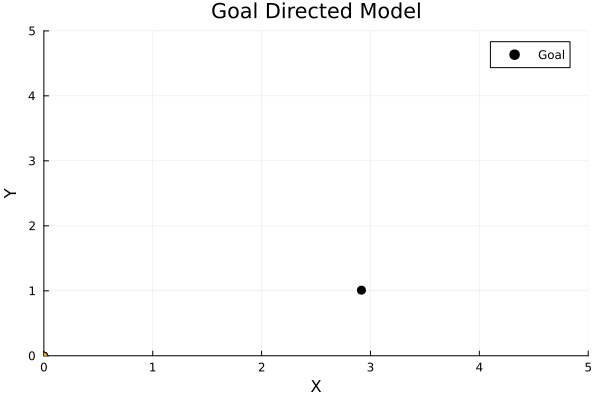

In [13]:
# Animate trajectories

# Simulate and animate goalDirectedModel with grid
function animate_goal_directed_grid(T::Int, initX, initY; num_traces = 1, fps = 3, plot_goal = false)
    # Specify a color palette for each trace
    color_palette = [:blue, :green, :red, :purple, :orange]

    plt = plot()

    anim = @animate for t in 1:T
        trace = Gen.simulate(goalDirectedModel, (T, initX, initY))
        xs, ys, goalX, goalY = get_retval(trace)

        # Plot the goal (constant in a single trial)
        if t == 1 && plot_goal
            scatter!([goalX], [goalY], label="Goal", color=:black, markersize=5, seriestype=:scatter)
        end

        for trace_id in 1:min(num_traces, length(color_palette))
            # Specify color for each trace
            scatter!([xs[t]], [ys[t]], title = "Goal Directed Model", xlabel = "X", ylabel = "Y", label=nothing, seriestype=:scatter, color=color_palette[trace_id], xlims=(0,5), ylims=(0,5))
        end
    end

    gif(anim, fps = fps)
end

# Simulate and animate goalDirectedModel with grid (including goal plotting)
T = 50
initX_rw, initY_rw = 0.0, 0.0
animate_goal_directed_grid(T, initX_rw, initY_rw, num_traces=50, plot_goal=true)


### New Yorker Model

In [14]:
@gen function NewYorkerModel(T::Int, initX, initY)
    measurement_noise = 0.0005
    step_var = 1e-4 # reduced step variance

    xs = Vector{Float64}(undef, T+1)
    ys = Vector{Float64}(undef, T+1)

    # Setting initial x-coordinate
    x = initX

    # Setting initial y-coordinate
    y = initY
   
    # Record position
    xs[1] = x
    ys[1] = y
   
    # Sample goalX and goalY between 0 and 5
    goalX, goalY = @trace(uniform(0.0, 5.0), :goalX), @trace(uniform(0.0, 5.0), :goalY)
   
    # Declare prior for the noise
    noise ~ trunc_norm(0.0, 1.0, 0.0, 5.0)  # Adjust parameters as needed
   
    # Generate successive states and measurements
    for t=1:T
        # Calculate the direction and distance to the goal
        dx = goalX - x
        dy = goalY - y

        # Add some uncertainty
        dx += normal(0.0, 0.1) # decreased uncertainty
        dy += normal(0.0, 0.1) # decreased uncertainty

        # Normalize the direction vector
        norm_factor = sqrt(dx^2 + dy^2)
        dx /= norm_factor
        dy /= norm_factor

        # Take a step towards the goal using trunc_norm
        step_size_x = {(:step => t => :x)} ~ trunc_norm(0.0, sqrt(step_var), 0.0, 5.0)
        step_size_y = {(:step => t => :y)} ~ trunc_norm(0.0, sqrt(step_var), 0.0, 5.0)

        # Record position
        x += normal(step_size_x * dx, 1e-6)
        y += normal(step_size_y * dy, 1e-6)
        
        xs[t+1] = x
        ys[t+1] = y
    end

    # Return the sequence of positions and sampled goal coordinates
    return (xs, ys)
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##NewYorkerModel#354", Bool[0, 0, 0], false)

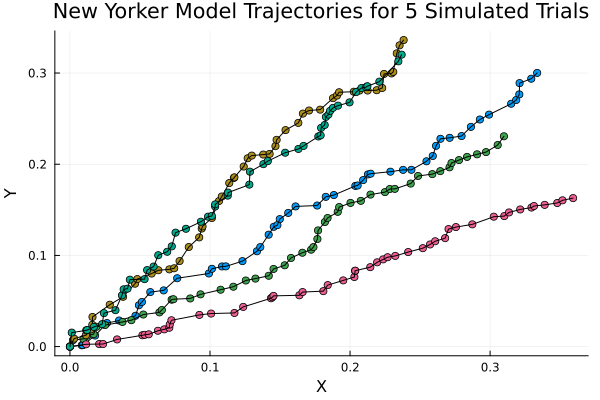

In [15]:
# Simulate multiple trials for NewYorkerModel with lines
T = 50
num_trials = 5
initX_ny, initY_ny = 0.0, 0.0

plt_ny = plot(title = "New Yorker Model Trajectories for $num_trials Simulated Trials", xlabel = "X", ylabel = "Y")

for _ in 1:num_trials
    trace_ny = Gen.simulate(NewYorkerModel, (T, initX_ny, initY_ny))
    xs_ny, ys_ny = get_retval(trace_ny)
    
    # Plot points
    scatter!(plt_ny, xs_ny, ys_ny, label=nothing, seriestype=:scatter, legend=false)
    
    # Plot lines between consecutive steps
    plot!(plt_ny, xs_ny, ys_ny, label=nothing, seriestype=:line, color=:black)
end

display(plt_ny)


### Tourist Model

In [16]:
@gen function touristModel(T::Int, initX, initY)
    measurement_noise = 0.05 # increased noise
    step_var = 0.5 # increased step variance

    xs = Vector{Float64}(undef, T+1)
    ys = Vector{Float64}(undef, T+1)

    # Setting initial x-coordinate
    x = initX

    # Setting initial y-coordinate
    y = initY
   
    # Record position
    xs[1] = x
    ys[1] = y
   
    # Sample goalX and goalY between 0 and 5
    goalX, goalY = @trace(uniform(0.0, 5.0), :goalX), @trace(uniform(0.0, 5.0), :goalY)
   
    # Declare prior for the noise
    noise ~ trunc_norm(0.0, 1.0, 0.0, 5.0)  # Adjust parameters as needed
   
    # Generate successive states and measurements
    for t=1:T
        # Calculate the direction and distance to the goal
        dx = goalX - x
        dy = goalY - y

        # Add some uncertainty
        dx += normal(0.0, 0.4) #increased uncertainty
        dy += normal(0.0, 0.4) #increased uncertainty

        # Normalize the direction vector
        norm_factor = sqrt(dx^2 + dy^2)
        dx /= norm_factor
        dy /= norm_factor

        # Take a step towards the goal using trunc_norm
        step_size_x = {(:step => t => :x)} ~ trunc_norm(0.0, sqrt(step_var), 0.0, 5.0)
        step_size_y = {(:step => t => :y)} ~ trunc_norm(0.0, sqrt(step_var), 0.0, 5.0)

        # Record position
        x += normal(step_size_x * dx, 1e-6)
        y += normal(step_size_y * dy, 1e-6)
        
        xs[t+1] = x
        ys[t+1] = y
    end

    # Return the sequence of positions and sampled goal coordinates
    return (xs, ys)
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##touristModel#356", Bool[0, 0, 0], false)

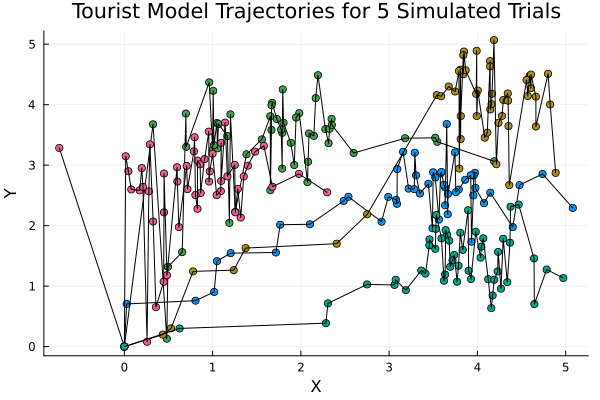

In [17]:
# Simulate multiple trials for NewYorkerModel with lines
T = 50
num_trials = 5
initX_ny, initY_ny = 0.0, 0.0

plt_tour = plot(title = "Tourist Model Trajectories for $num_trials Simulated Trials", xlabel = "X", ylabel = "Y")

for _ in 1:num_trials
    trace_tour = Gen.simulate(touristModel, (T, initX_ny, initY_ny))
    xs_tour, ys_tour = get_retval(trace_tour)
    
    # Plot points
    scatter!(plt_tour, xs_tour, ys_tour, label=nothing, seriestype=:scatter, legend=false)
    
    # Plot lines between consecutive steps
    plot!(plt_tour, xs_tour, ys_tour, label=nothing, seriestype=:line, color=:black)
end

display(plt_tour)

## Building a Switch Combinator with Bernoulli distribution

In [24]:
# Define the models
models = (randomWalkModel, NewYorkerModel, touristModel)

# Create a switch model with randomWalkModel, NewYorkerModel, and touristModel
agentSwitch = Gen.Switch(models...)

# Specify the model choice (1, 2, or 3)
i = 1

#Specify the number of models
n = 3

# Trace the model with specific arguments
trace = @gen function my_switch_model(T, initX, initY)
    # Create a dictionary with the model choice
    choices = Dict(:model => i)

    # Use Switch to choose the appropriate model based on the choice
    return @trace(agentSwitch(choices, T, initX, initY))
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##my_switch_model#365", Bool[0, 0, 0], false)

In [25]:
@gen function switchModel(T, initX, initY)
	model ~ categorical(fill(1/n, n))
actions~ agentSwitch(model, T, initX, initY)
return actions
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##switchModel#366", Bool[0, 0, 0], false)

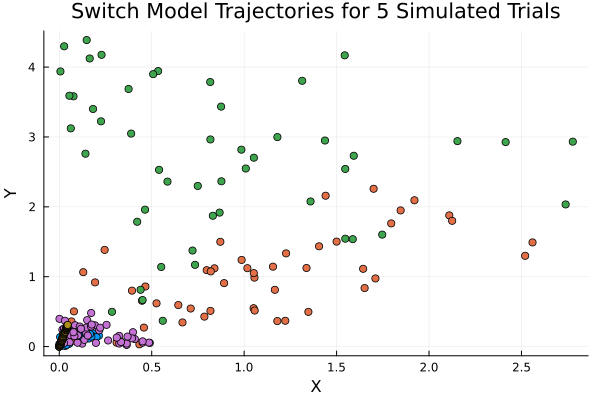

In [37]:
# Number of trials
num_trials = 5

# Time steps
T = 50

# Initial positions
initX, initY = 0.0, 0.0

# Define the models
models = (randomWalkModel, NewYorkerModel, touristModel)

# Create a switch model with randomWalkModel, NewYorkerModel, and touristModel
agentSwitch = Gen.Switch(models...)

# Function to simulate and plot trajectories for switchModel
function simulate_and_plot_switch_model(num_trials, T, initX, initY)
    plt_switch = plot(title="Switch Model Trajectories for $num_trials Simulated Trials", xlabel="X", ylabel="Y")

    for trial in 1:num_trials
        # Specify the model choice (1, 2, or 3)
        i = rand(1:3)

        # Simulate the model
        trace = @gen function my_switch_model(T, initX, initY)
            # Use Switch to choose the appropriate model based on the choice
            choice = @trace(bernoulli(1/3), :choice)
            if choice
                return @trace(randomWalkModel(T, initX, initY))
            elseif !choice
                return @trace(NewYorkerModel(T, initX, initY))
            end
        end

        # Simulate the model
        trace = Gen.simulate(my_switch_model, (T, initX, initY))

        # Access the trace and results
        xs, ys = Gen.get_retval(trace)

        # Plot the trajectory with lines
        plot!(plt_switch, xs, ys, seriestype=:scatter, connect=:true, label=:none)
    end

    display(plt_switch)
end

# Simulate and plot trajectories for switchModel
simulate_and_plot_switch_model(num_trials, T, initX, initY)


[ Info: Saved animation to /vast/palmer/home.grace/psyc261_mi337/Algorithms-of-the-Mind/term_project/tmp.gif


Plots.AnimatedGif("/vast/palmer/home.grace/psyc261_mi337/Algorithms-of-the-Mind/term_project/tmp.gif")
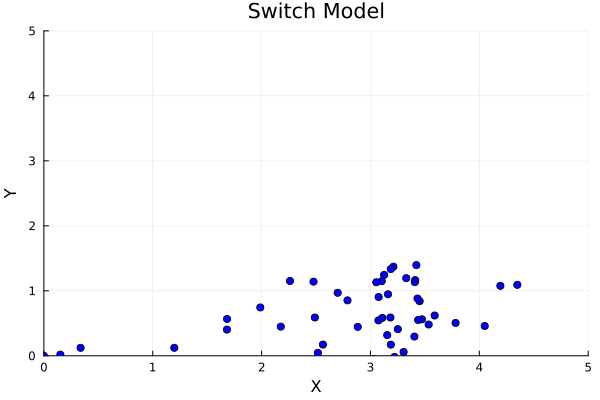

In [27]:
# Animate switch_model with grid
function animate_switch_model(T::Int, initX, initY; num_traces = 1, fps = 2)
    # Specify a color palette for each trace
    color_palette = [:blue, :green, :red, :purple, :orange]

    plt = plot()

    anim = @animate for trace_id in 1:num_traces
        trace = Gen.simulate(switchModel, (T, initX, initY))
        xs, ys = get_retval(trace)

        for t in 1:T
            # Specify color for each trace
            scatter!([xs[t]], [ys[t]], title = "Switch Model", xlabel = "X", ylabel = "Y", label=nothing, seriestype=:scatter, color=color_palette[trace_id], xlims=(0,5), ylims=(0,5))
        end
    end

    gif(anim, fps = fps)
end

# Simulate and animate switch_model with grid
T = 50
initX, initY = 0.0, 0.0
goalX, goalY = 3.0, 3.0
animate_switch_model(T, initX, initY, num_traces=5)

In [28]:
## Another way to define the Switch Combinator

#@gen function switchModel(T::Int, initX, initY)
#    choice ~ bernoulli(0.5)
#    if choice
#        return goalDirectedModel(T, initX, initY)
#    else
#        return randomWalkModel(T, initX, initY)
#    end
#end

## Making Inferences

In [29]:
(trace, _) = Gen.generate(switchModel, (50, 0.0, 0.0))
Gen.get_choices(trace)

│
├── :model : 2
│
└── :actions
    │
    ├── :goalY : 0.23182171124381312
    │
    ├── :noise : 1.3668074854051073
    │
    ├── :goalX : 3.0019624581805457
    │
    └── :step
        │
        ├── 5
        │   │
        │   ├── :y : 0.0023488218990980474
        │   │
        │   └── :x : 0.009469136016503054
        │
        ├── 35
        │   │
        │   ├── :y : 0.006570626273743314
        │   │
        │   └── :x : 0.009959040152006332
        │
        ├── 30
        │   │
        │   ├── :y : 0.0049868599862184886
        │   │
        │   └── :x : 0.0006330442981834187
        │
        ├── 32
        │   │
        │   ├── :y : 0.006471924623567438
        │   │
        │   └── :x : 0.014177712250872348
        │
        ├── 6
        │   │
        │   ├── :y : 0.009127941661046848
        │   │
        │   └── :x : 0.00042331539621481265
        │
        ├── 45
        │   │
        │   ├── :y : 0.018385376539353238
        │   │
        │   └── :x : 0.008066583282612

In [43]:
# Function to make synthetic dataset for the Switch Combinator Model
function make_synthetic_dataset_switch(num_trials, T)
    #Random.seed!(1)
    observations = []

    for i in 1:num_trials
        # Specify the model choice (1, 2, or 3)
        model_choice = rand(1:3)

        if model_choice == 1
            (xs, ys) = randomWalkModel(T, 0.0, 0.0)
            push!(observations, DynamicChoiceMap((:trial => :random_walk => i => :xs) => xs, (:trial => :random_walk => i => :ys) => ys, (:trial => :random_walk => i => :choice) => model_choice))
        elseif model_choice == 2
            (xs, ys) = NewYorkerModel(T, 0.0, 0.0)
            push!(observations, DynamicChoiceMap((:trial => :new_yorker => i => :xs) => xs, (:trial => :new_yorker => i => :ys) => ys, (:trial => :new_yorker => i => :choice) => model_choice))
        else
            (xs, ys) = touristModel(T, 0.0, 0.0)
            push!(observations, DynamicChoiceMap((:trial => :tourist => i => :xs) => xs, (:trial => :tourist => i => :ys) => ys, (:trial => :tourist => i => :choice) => model_choice))
        end
    end

    return observations
end

make_synthetic_dataset_switch (generic function with 1 method)

In [44]:
num_trials = 20
T = 10
obs = make_synthetic_dataset(num_trials, T)

20-element Vector{Any}:
 DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(:trial => DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(:goal_directed => DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(1 => DynamicChoiceMap(Dict{Any, Any}(:ys => [0.0, 0.10324429563855733, 0.10501314148782674, 0.23955332328388373, 0.32865578181254135, 0.4349438451780076, 0.4871844963141237, 0.6201482006372336, 0.6911699648694059, 0.7076900718653758, 0.7573663153786725], :choice => true, :xs => [0.0, 0.08525678498370516, 0.09712171027009237, 0.1339612923075562, 0.16862551631617984, 0.19644534518704646, 0.24452032500347787, 0.287927141587472, 0.33072407128375286, 0.35395940785204283, 0.44252513406408517]), Dict{Any, Any}())))))))
 DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(:trial => DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(:goal_directed => DynamicChoiceMap(Dict{Any, Any}(), Dict{Any, Any}(2 => DynamicChoiceMap(Dict{Any, Any}(:ys => [0.0, 0.08334913763378836, 0.09006613272842934, 0.134187

In [45]:
xs = zeros(num_trials, T)
ys = zeros(num_trials, T)

for i in 1:num_trials
    for t in 1:T
        obs[:trial => i => :step => t => :x] = xs[i, t]
        obs[:trial => i => :step => t => :y] = ys[i, t]
    end
end

trace, ls = Gen.generate(switchModel, (T, initX, initY), obs)

steps = 10

for i = 1:steps
	trace, accepted = mh(trace, select(:model))
	traces[i] = trace
end

LoadError: ArgumentError: invalid index: :trial => (1 => (:step => (1 => :x))) of type Pair{Symbol, Pair{Int64, Pair{Symbol, Pair{Int64, Symbol}}}}